<a href="https://colab.research.google.com/github/Bright-Momo/SimplifiedJournalsGame/blob/main/lam_and_epsilon_dynamic_replicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

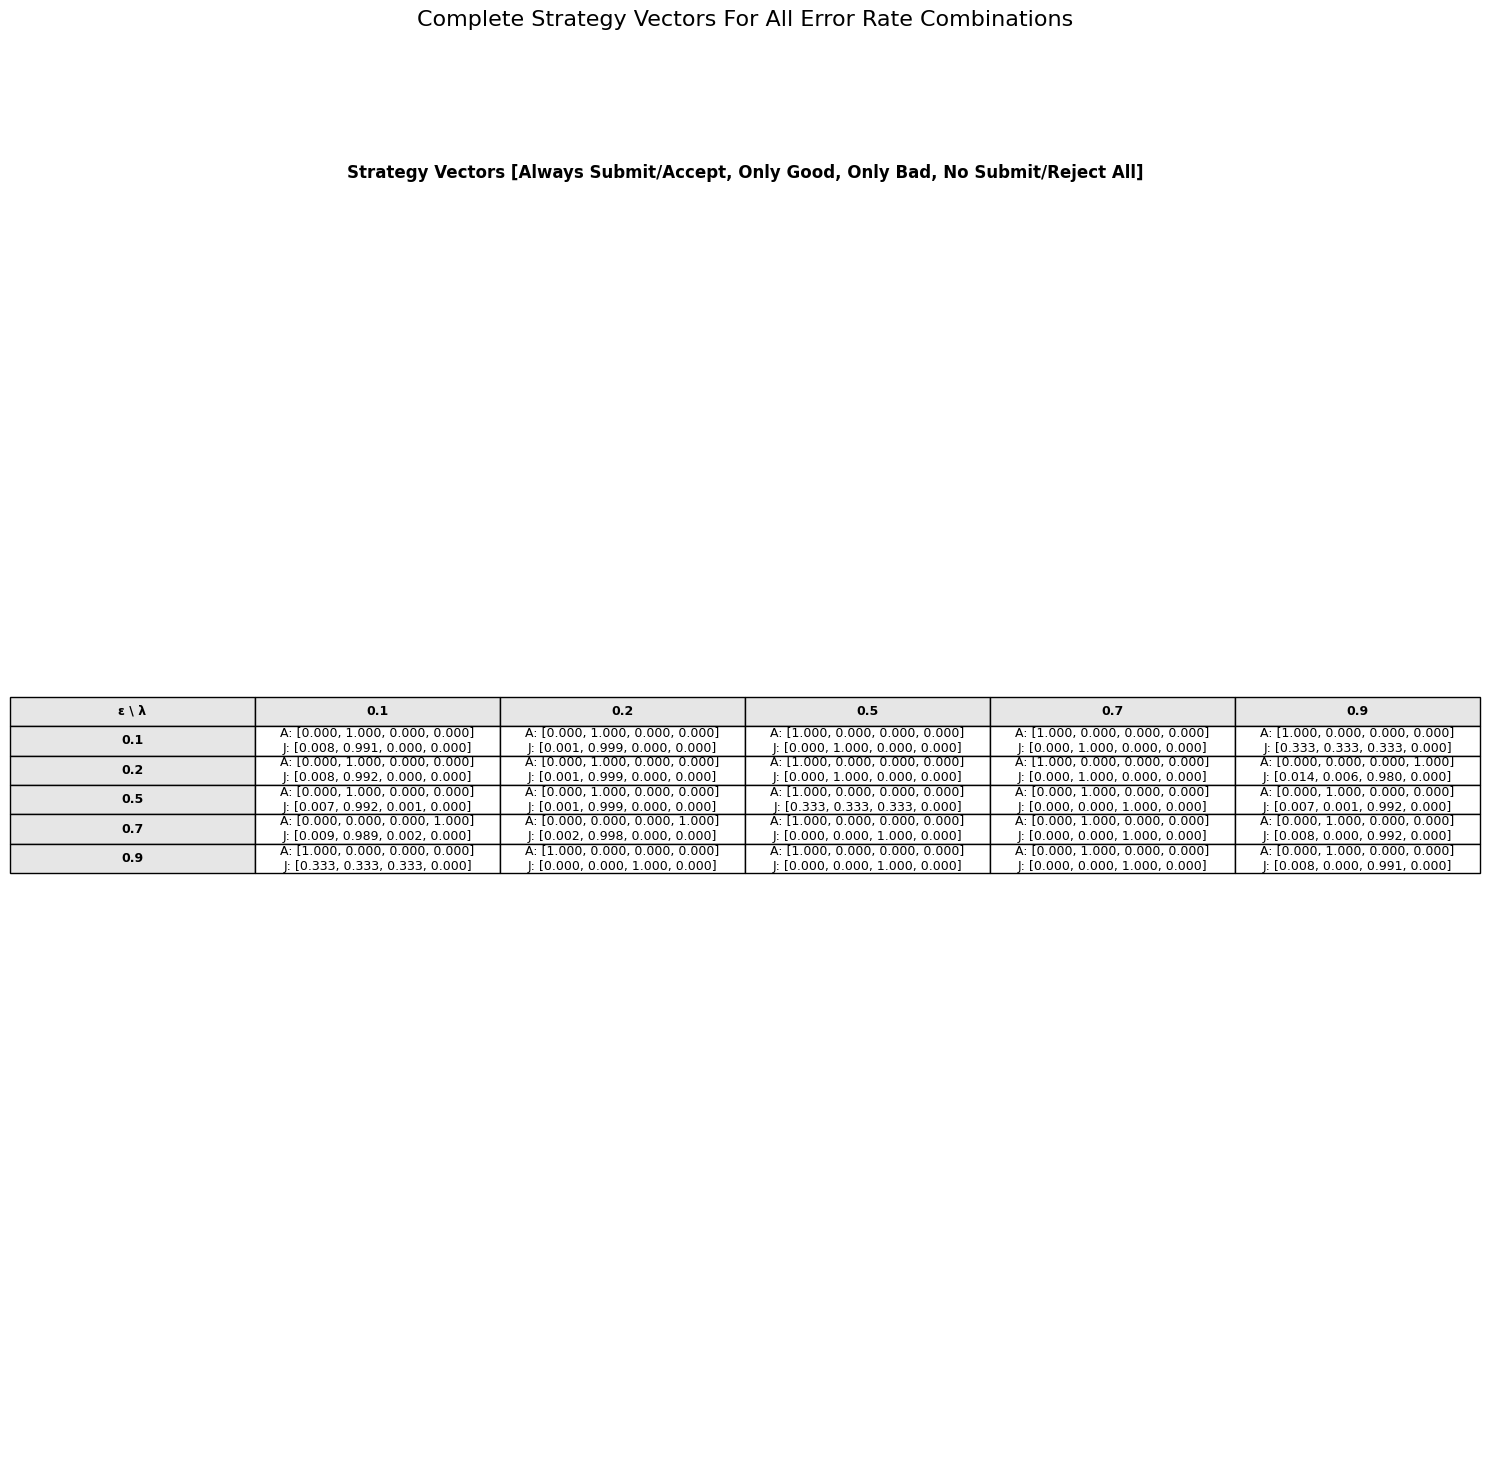

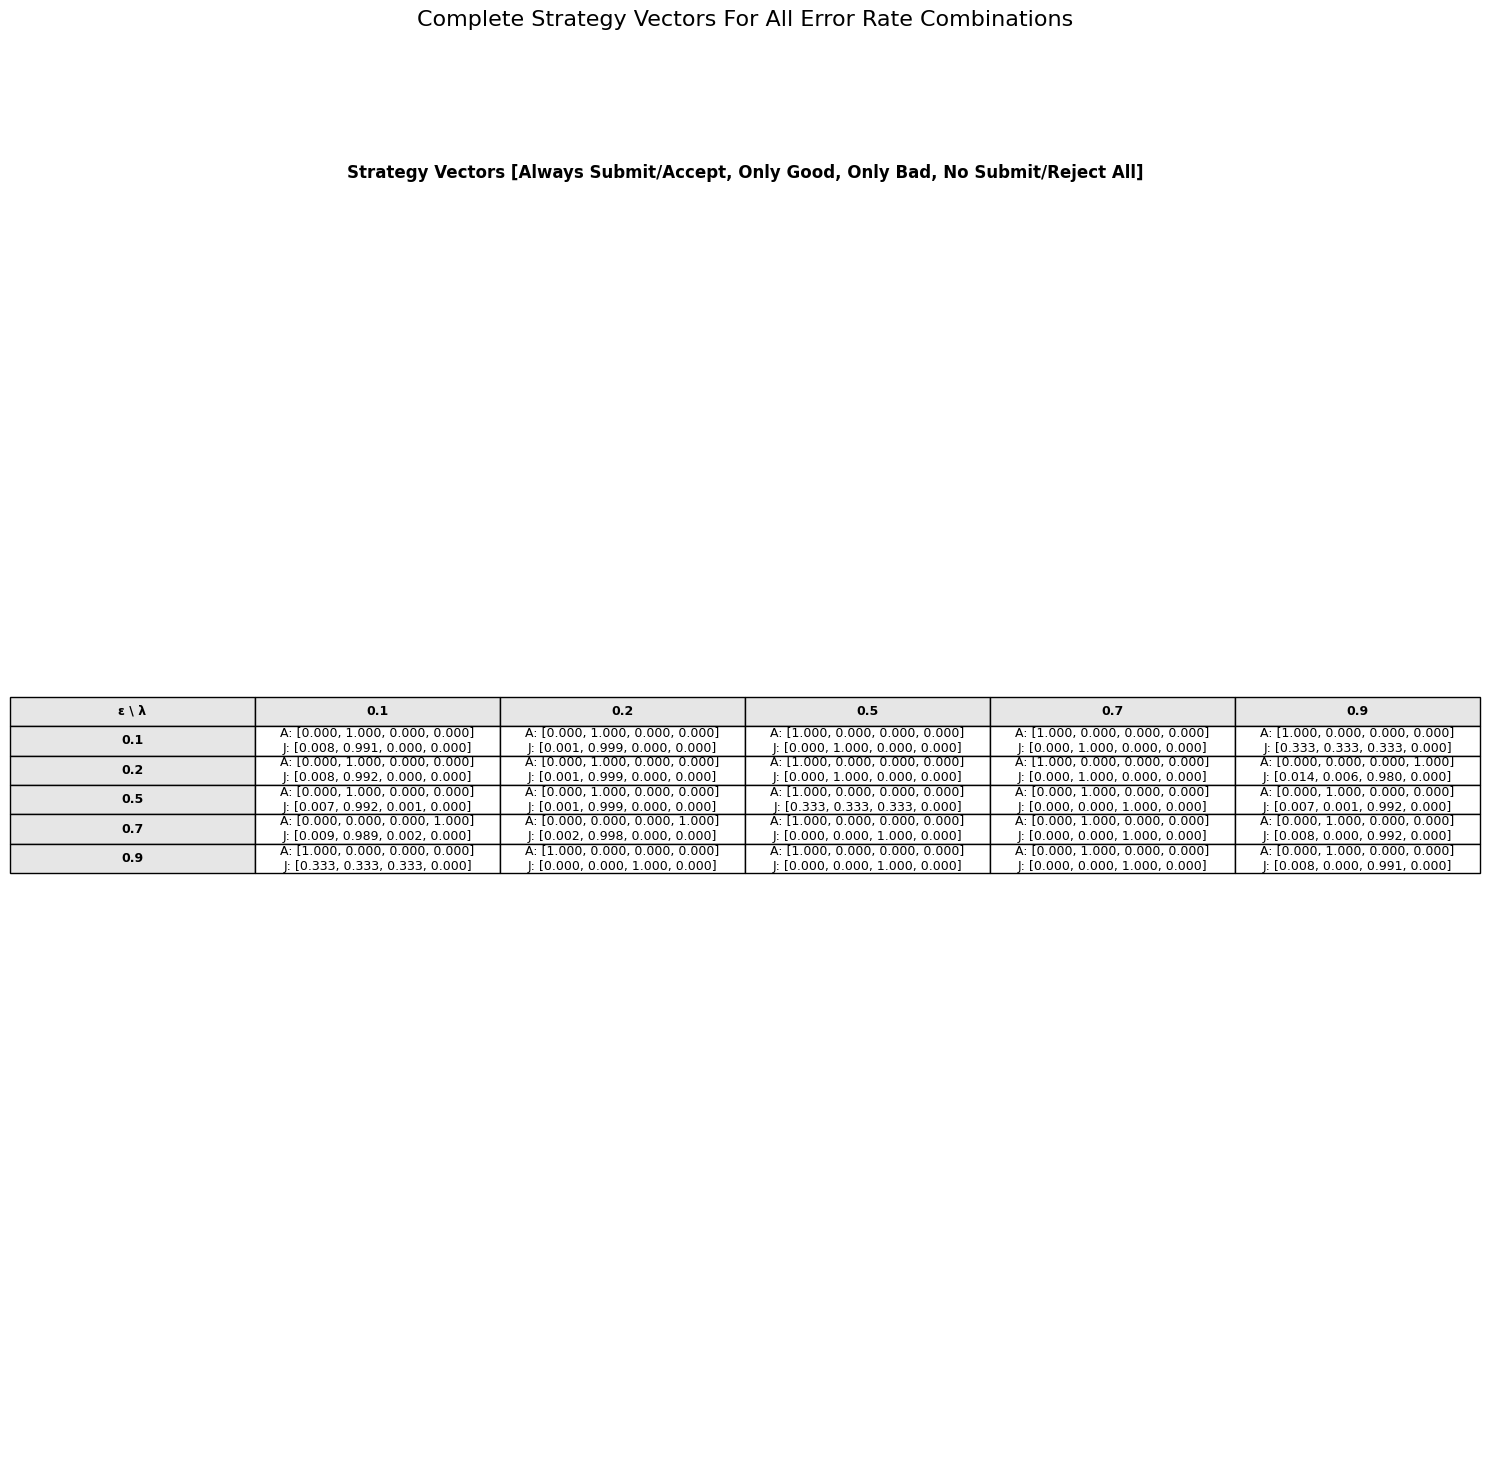

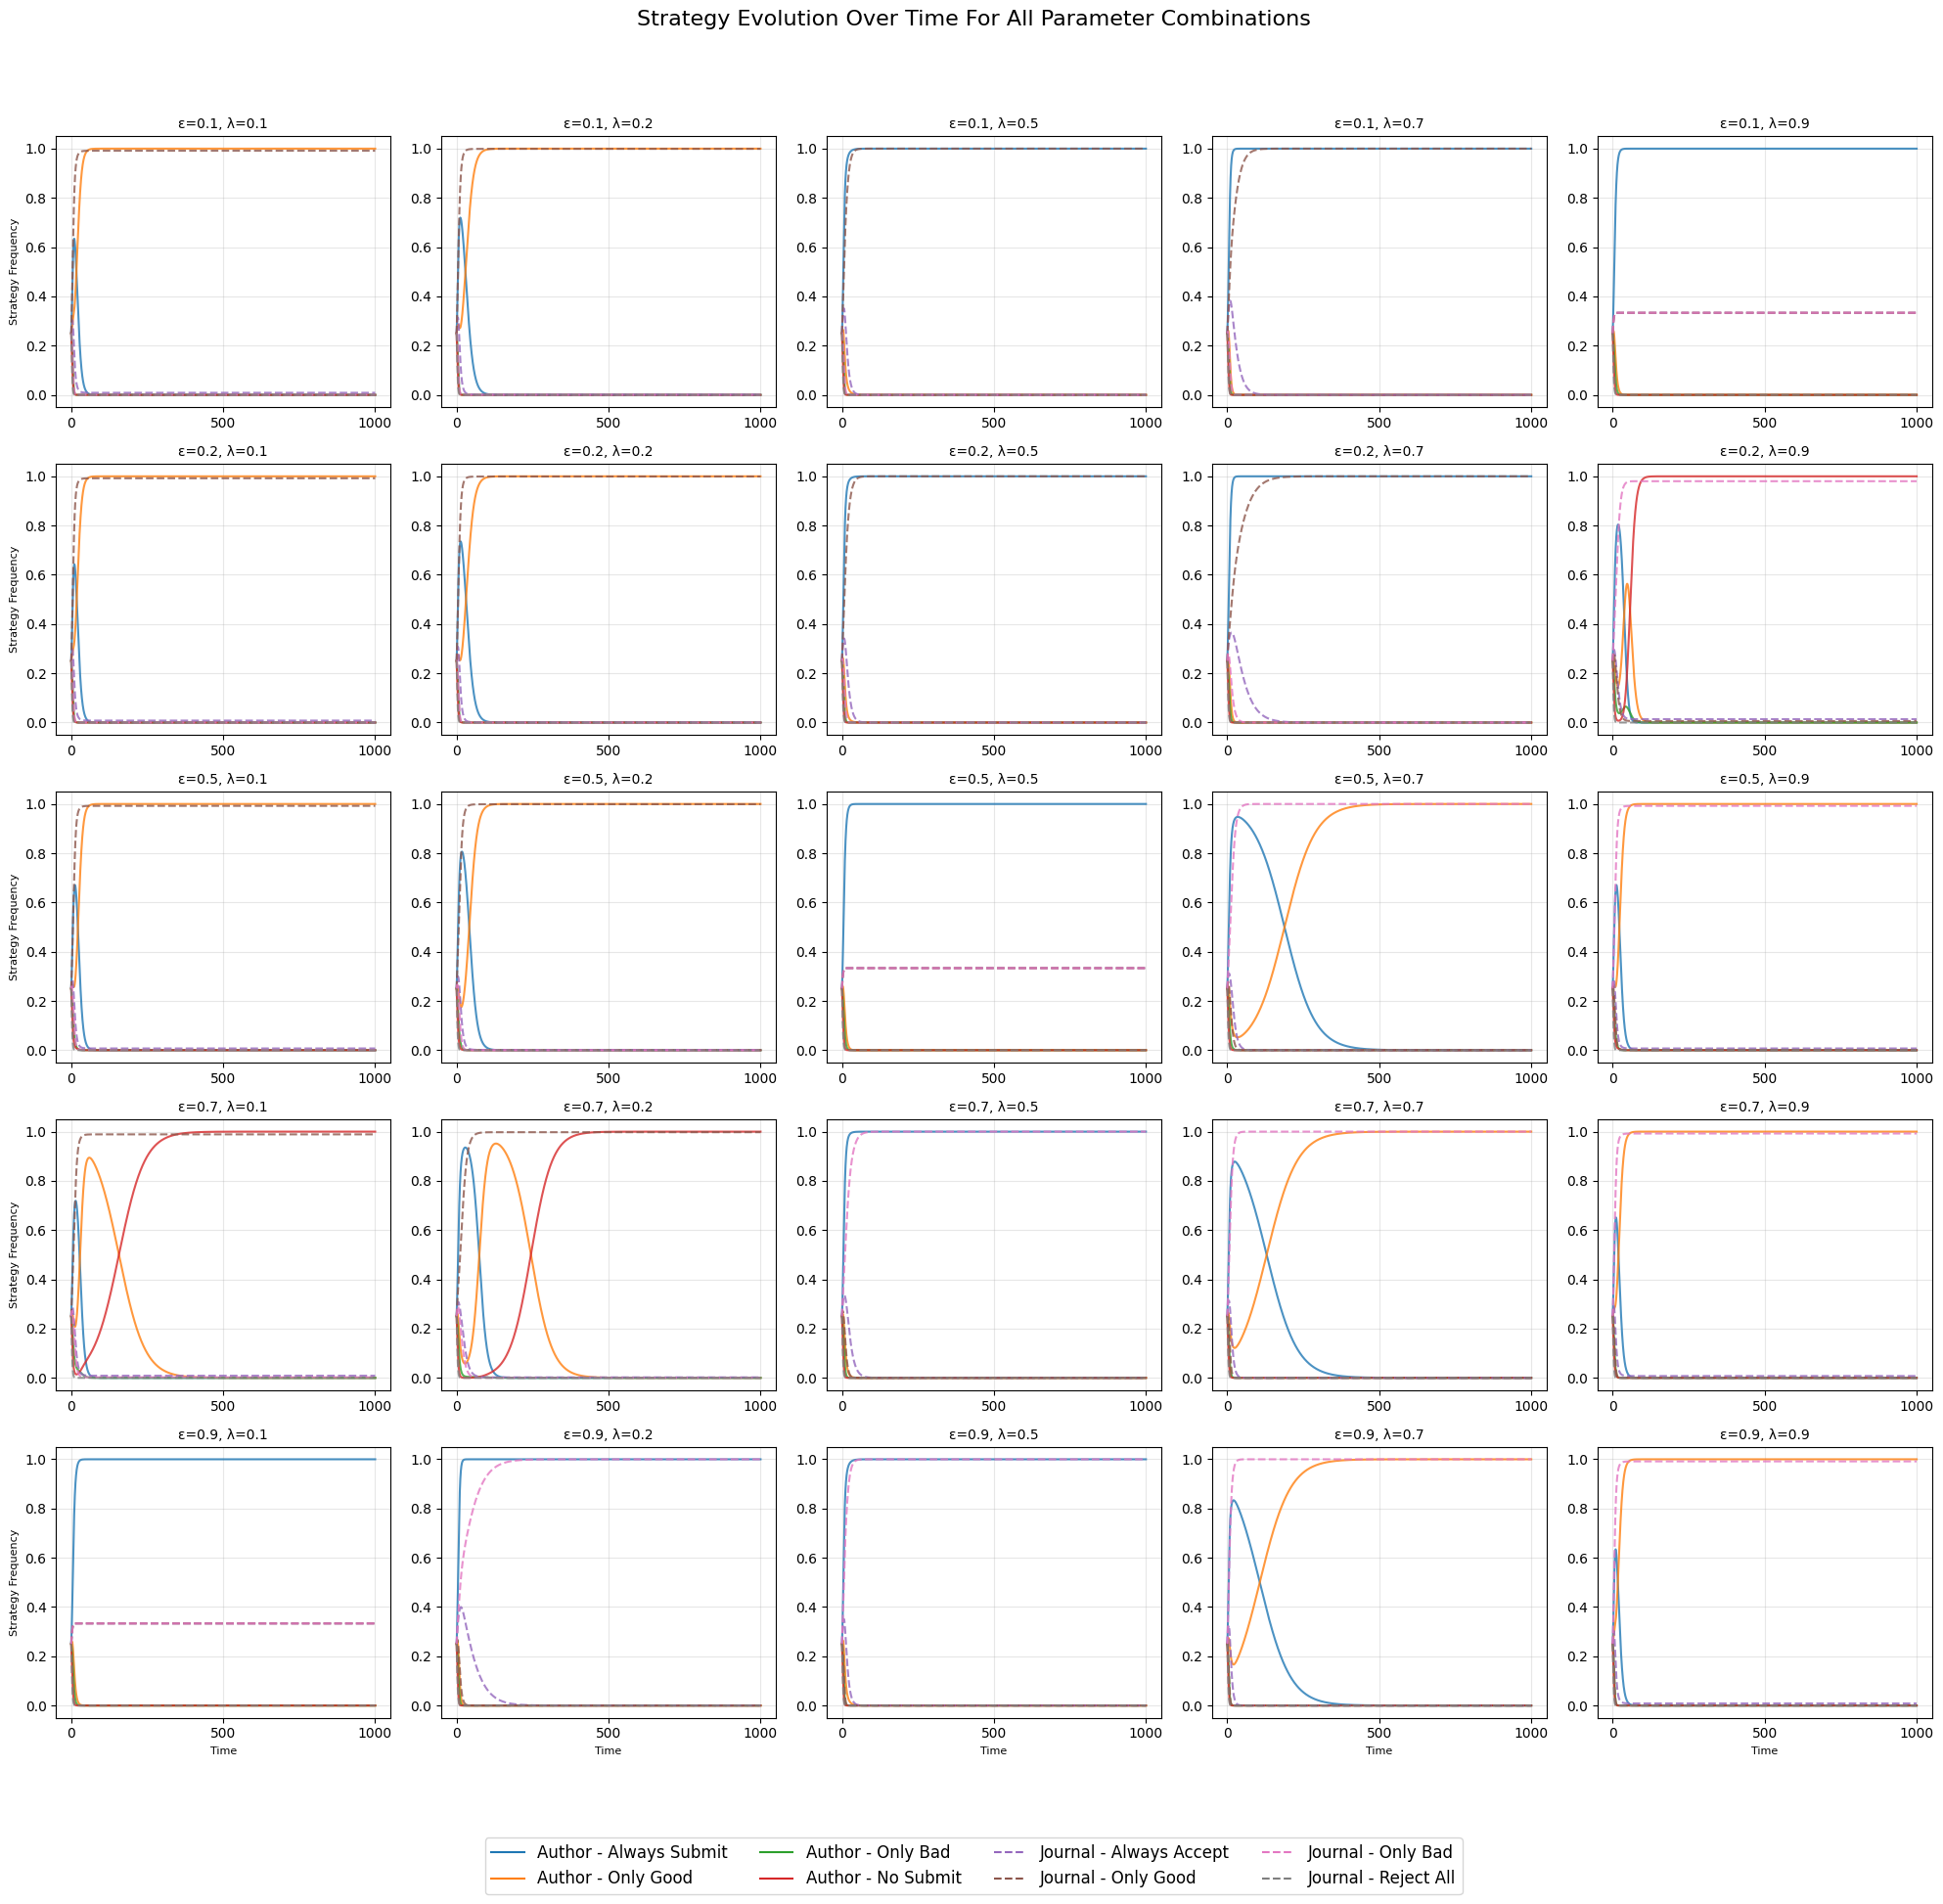

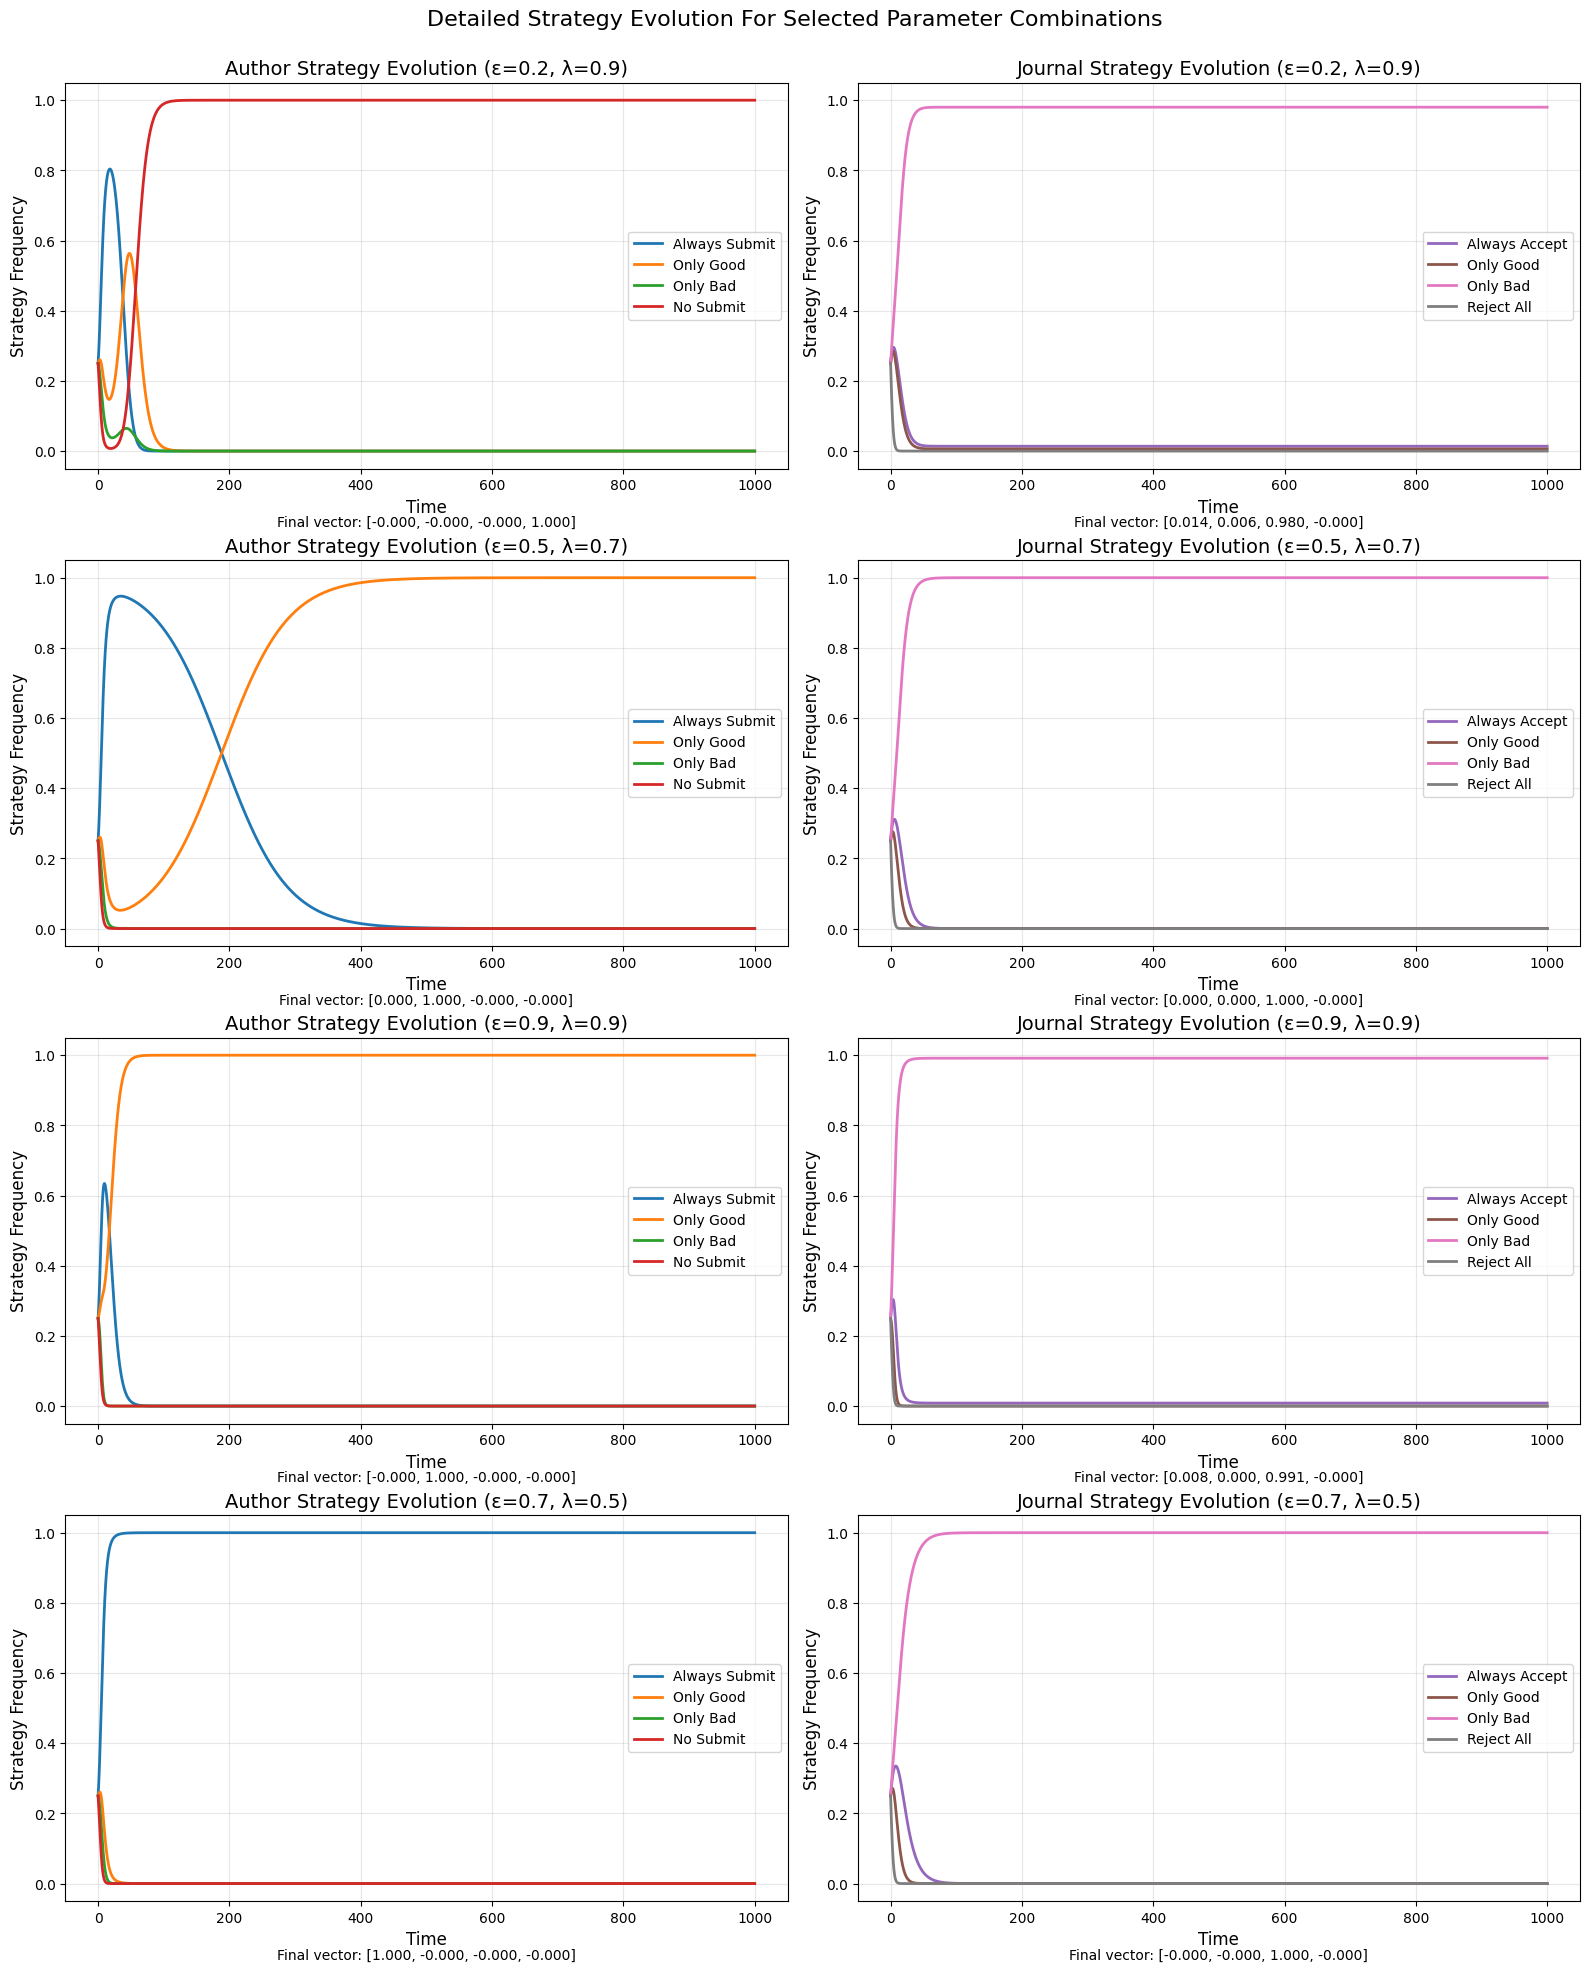

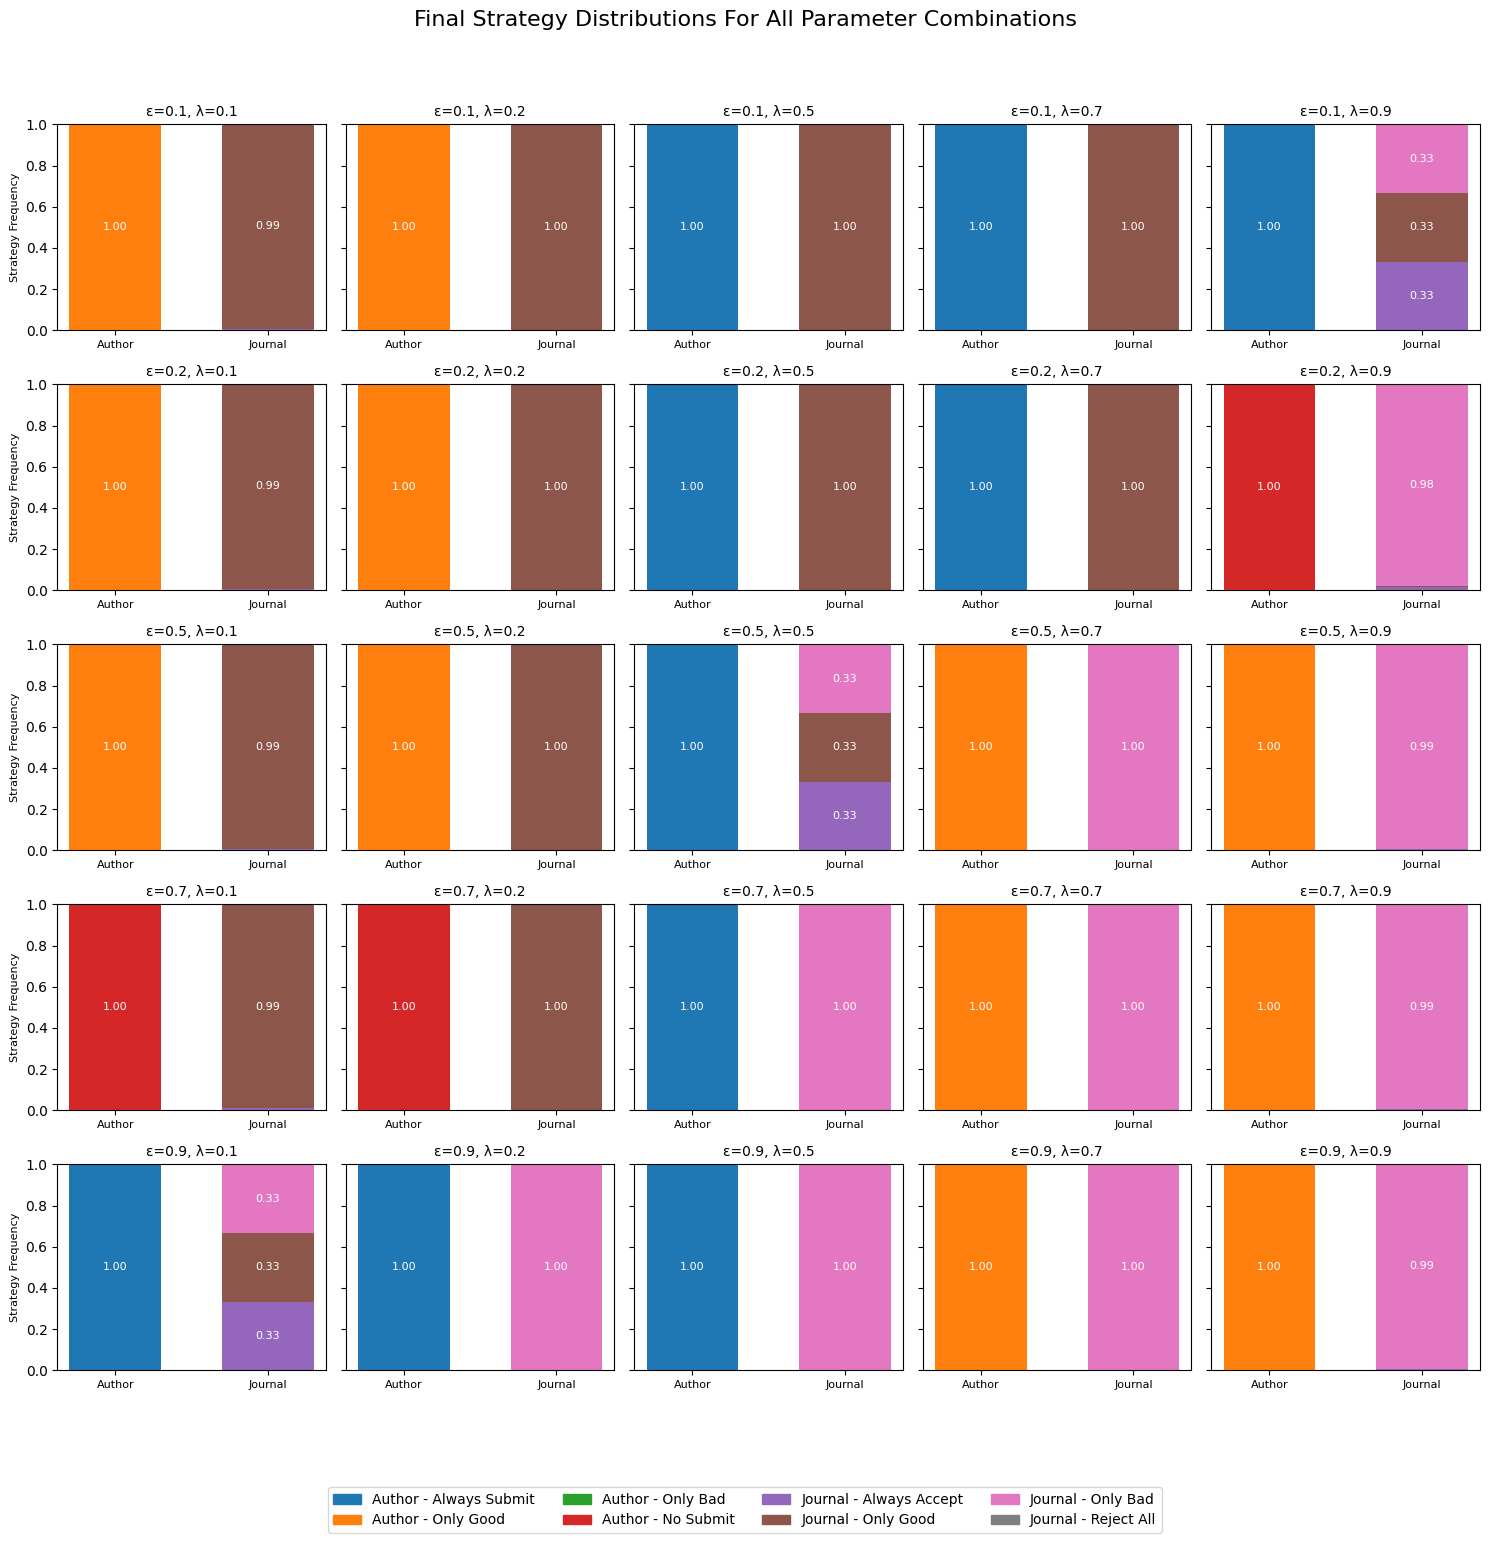

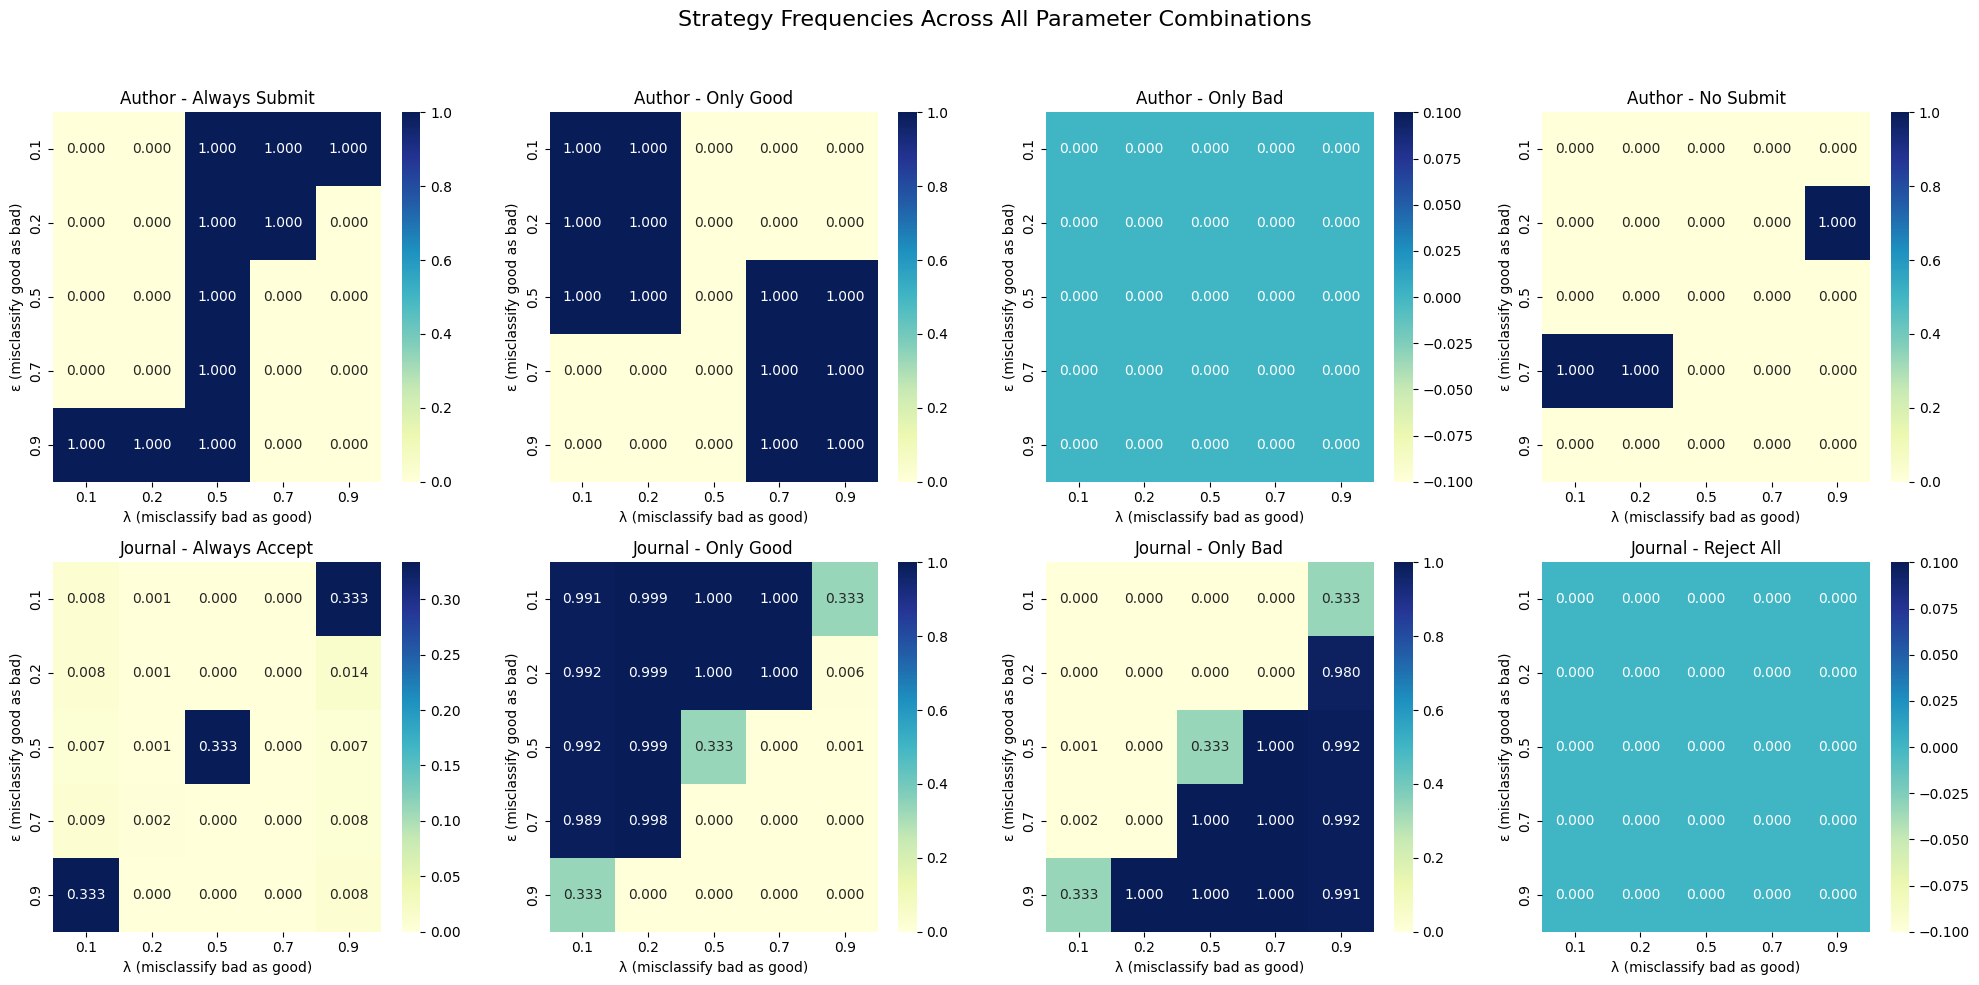

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.integrate import odeint
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

# Parameters (constant)
alpha = 0.6    # Probability of a good paper
r = 1.0        # Reward for author when accepted
c = 0.5        # Cost for author when rejected
gamma = 0.1    # Cost for journal when reviewing a paper

def acceptance_probability(is_good_paper, journal_strategy, epsilon, lam):
    if journal_strategy == 0:  # Always Accept
        return 1.0
    elif journal_strategy == 1:  # Only Accept Good
        return 1 - epsilon if is_good_paper else lam
    elif journal_strategy == 2:  # Only Accept Bad
        return epsilon if is_good_paper else 1 - lam
    else:  # Reject All
        return 0.0

def author_journal_payoff(author_strategy, journal_strategy, epsilon, lam):
    if author_strategy == 0:
        good_prob, bad_prob = alpha, 1 - alpha
    elif author_strategy == 1:
        good_prob, bad_prob = alpha, 0
    elif author_strategy == 2:
        good_prob, bad_prob = 0, 1 - alpha
    else:
        good_prob, bad_prob = 0, 0

    p_accept_good = acceptance_probability(True, journal_strategy, epsilon, lam)
    p_accept_bad = acceptance_probability(False, journal_strategy, epsilon, lam)

    accept_rate = good_prob * p_accept_good + bad_prob * p_accept_bad
    submit_rate = good_prob + bad_prob
    reject_rate = submit_rate - accept_rate

    author_payoff = accept_rate * r - reject_rate * c

    # Payoff equation
    if accept_rate > 0:
        journal_payoff = (good_prob * p_accept_good) / accept_rate - gamma * submit_rate
    else:
        journal_payoff = 0  # pay nothing if no receive paper

    return author_payoff, journal_payoff

def build_payoff_matrices(epsilon, lam):
    num_strategies = 4

    # Initialize payoff matrices
    author_payoff_matrix = np.zeros((num_strategies, num_strategies))
    journal_payoff_matrix = np.zeros((num_strategies, num_strategies))

    # Calculate payoffs for all strategy combinations
    for i in range(num_strategies):
        for j in range(num_strategies):
            author_pay, journal_pay = author_journal_payoff(i, j, epsilon, lam)
            author_payoff_matrix[i, j] = author_pay
            journal_payoff_matrix[i, j] = journal_pay

    return author_payoff_matrix, journal_payoff_matrix

def replicator_dynamics(y, t, author_matrix, journal_matrix):
    # Strategy frequencies
    author_freqs = y[:4]
    journal_freqs = y[4:]

    # Frequencies are valid
    author_freqs = np.clip(author_freqs, 0, 1)
    journal_freqs = np.clip(journal_freqs, 0, 1)

    # Sum equals 1
    author_freqs = author_freqs / np.sum(author_freqs)
    journal_freqs = journal_freqs / np.sum(journal_freqs)

    # Expected payoffs for each strategy
    author_expected_payoffs = np.dot(author_matrix, journal_freqs)
    journal_expected_payoffs = np.dot(author_freqs, journal_matrix)

    # Average payoffs
    avg_author_payoff = np.dot(author_freqs, author_expected_payoffs)
    avg_journal_payoff = np.dot(journal_freqs, journal_expected_payoffs)

    # Replicator equation
    author_derivs = author_freqs * (author_expected_payoffs - avg_author_payoff)
    journal_derivs = journal_freqs * (journal_expected_payoffs - avg_journal_payoff)

    # Combine derivatives and return
    return np.concatenate([author_derivs, journal_derivs])

def simulate_dynamics_for_parameters(epsilon, lam):
    author_matrix, journal_matrix = build_payoff_matrices(epsilon, lam)

    # Initial conditions: equal distribution among strategies
    initial_freqs = np.ones(8) / 4.0
    t = np.arange(0, 1000.1, 0.1)  # As requested, t=1000 with step=0.1

    solution = odeint(replicator_dynamics, initial_freqs, t, args=(author_matrix, journal_matrix))

    return t, solution, author_matrix, journal_matrix

# Define strategy names and colors
author_strategies = ["Always Submit", "Only Good", "Only Bad", "No Submit"]
journal_strategies = ["Always Accept", "Only Good", "Only Bad", "Reject All"]
author_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
journal_colors = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# Parameter values to analyze
param_values = [0.1, 0.2, 0.5, 0.7, 0.9]

# Run simulations for all parameter combinations and collect results
results = []
for e in param_values:
    for l in param_values:
        t, solution, author_matrix, journal_matrix = simulate_dynamics_for_parameters(e, l)

        # Final state
        final_state = solution[-1, :]
        author_final = final_state[:4]
        journal_final = final_state[4:]

        # Normalize to ensure they sum to 1
        author_final = author_final / np.sum(author_final)
        journal_final = journal_final / np.sum(journal_final)

        # Clip any negative values (due to numerical issues)
        author_final = np.clip(author_final, 0, 1)
        journal_final = np.clip(journal_final, 0, 1)

        # Add to results
        results.append({
            'epsilon': e,
            'lambda': l,
            't': t,
            'solution': solution,
            'author_matrix': author_matrix,
            'journal_matrix': journal_matrix,
            'author_final': author_final,
            'journal_final': journal_final
        })

# Create a comprehensive table of all strategy vectors
def create_complete_strategy_table():
    # Create figure with a single axes for the table
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.axis('off')

    # Create a 2D table with epsilon values as rows and lambda values as columns
    table_data = []

    # Header row
    header = ['ε \\ λ'] + [f'{l}' for l in param_values]
    table_data.append(header)

    # Data rows
    for e in param_values:
        row = [f'{e}']
        for l in param_values:
            # Find the relevant result
            for result in results:
                if result['epsilon'] == e and result['lambda'] == l:
                    author = result['author_final']
                    journal = result['journal_final']

                    # Format the vector nicely
                    cell_text = f"A: [{', '.join([f'{v:.3f}' for v in author])}]\n" \
                               f"J: [{', '.join([f'{v:.3f}' for v in journal])}]"
                    row.append(cell_text)
                    break
        table_data.append(row)

    # Create the table
    table = ax.table(cellText=table_data, loc='center', cellLoc='center')

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)

    # Style the header row and column
    for i in range(len(header)):
        table[(0, i)].set_facecolor('#E6E6E6')
        table[(0, i)].set_text_props(weight='bold')

    for i in range(1, len(param_values) + 1):
        table[(i, 0)].set_facecolor('#E6E6E6')
        table[(i, 0)].set_text_props(weight='bold')

    # Add a legend/key for the strategy vectors
    ax.text(0.5, 0.95, "Strategy Vectors [Always Submit/Accept, Only Good, Only Bad, No Submit/Reject All]",
           ha='center', va='center', fontsize=12, weight='bold')

    plt.suptitle('Complete Strategy Vectors For All Error Rate Combinations', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    return fig

# Create visualizations of strategy evolution over time for each parameter combination
def create_evolution_grid():
    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(len(param_values), len(param_values), figure=fig)

    for i, e in enumerate(param_values):
        for j, l in enumerate(param_values):
            ax = fig.add_subplot(gs[i, j])

            # Find the relevant result
            for result in results:
                if result['epsilon'] == e and result['lambda'] == l:
                    t = result['t']
                    solution = result['solution']

                    # Plot author strategies
                    for k in range(4):
                        ax.plot(t, solution[:, k], color=author_colors[k],
                               label=author_strategies[k] if i == 0 and j == 0 else "",
                               linewidth=1.5, alpha=0.8)

                    # Plot journal strategies (dashed lines)
                    for k in range(4):
                        ax.plot(t, solution[:, k+4], color=journal_colors[k],
                               label=journal_strategies[k] if i == 0 and j == 0 else "",
                               linewidth=1.5, alpha=0.8, linestyle='--')

                    break

            # Set title and labels
            ax.set_title(f'ε={e}, λ={l}', fontsize=10)

            # Only show y-label for leftmost plots
            if j == 0:
                ax.set_ylabel('Strategy Frequency', fontsize=8)

            # Only show x-label for bottom plots
            if i == len(param_values) - 1:
                ax.set_xlabel('Time', fontsize=8)

            # Set axis limits
            ax.set_ylim(-0.05, 1.05)

            # Simplify x-ticks
            ax.set_xticks([0, 500, 1000])

            # Add a tiny grid
            ax.grid(True, alpha=0.3)

    # Create a common legend
    author_patches = [plt.Line2D([0], [0], color=author_colors[i], label=f'Author - {s}')
                     for i, s in enumerate(author_strategies)]
    journal_patches = [plt.Line2D([0], [0], color=journal_colors[i], linestyle='--',
                                 label=f'Journal - {s}')
                      for i, s in enumerate(journal_strategies)]

    fig.legend(handles=author_patches + journal_patches, loc='upper center',
              bbox_to_anchor=(0.5, 0.05), ncol=4, fontsize=12)

    plt.suptitle('Strategy Evolution Over Time For All Parameter Combinations', fontsize=16)
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])

    return fig

# Create a visualization of the strategy space for selected interesting cases
def create_strategy_space_visualization():
    # Select interesting cases with significant mixed strategies
    interesting_cases = [
        (0.2, 0.9),  # Notable mixed strategy for authors
        (0.5, 0.7),  # Another mixed case
        (0.9, 0.9),  # High error rates
        (0.7, 0.5)   # Reverse asymmetric errors
    ]

    fig, axes = plt.subplots(4, 2, figsize=(16, 20))

    for i, (e, l) in enumerate(interesting_cases):
        # Find the relevant result
        for result in results:
            if result['epsilon'] == e and result['lambda'] == l:
                t = result['t']
                solution = result['solution']

                # Plot author strategy evolution
                for k in range(4):
                    axes[i, 0].plot(t, solution[:, k], color=author_colors[k],
                                   label=author_strategies[k], linewidth=2)

                axes[i, 0].set_title(f'Author Strategy Evolution (ε={e}, λ={l})', fontsize=14)
                axes[i, 0].set_xlabel('Time', fontsize=12)
                axes[i, 0].set_ylabel('Strategy Frequency', fontsize=12)
                axes[i, 0].legend(fontsize=10)
                axes[i, 0].grid(True, alpha=0.3)
                axes[i, 0].set_ylim(-0.05, 1.05)

                # Plot journal strategy evolution
                for k in range(4):
                    axes[i, 1].plot(t, solution[:, k+4], color=journal_colors[k],
                                   label=journal_strategies[k], linewidth=2)

                axes[i, 1].set_title(f'Journal Strategy Evolution (ε={e}, λ={l})', fontsize=14)
                axes[i, 1].set_xlabel('Time', fontsize=12)
                axes[i, 1].set_ylabel('Strategy Frequency', fontsize=12)
                axes[i, 1].legend(fontsize=10)
                axes[i, 1].grid(True, alpha=0.3)
                axes[i, 1].set_ylim(-0.05, 1.05)

                # Add final strategy vectors as text
                final_author = solution[-1, :4]
                final_journal = solution[-1, 4:]

                # Normalize
                final_author = final_author / np.sum(final_author)
                final_journal = final_journal / np.sum(final_journal)

                author_text = f"Final vector: [{', '.join([f'{v:.3f}' for v in final_author])}]"
                journal_text = f"Final vector: [{', '.join([f'{v:.3f}' for v in final_journal])}]"

                axes[i, 0].text(0.5, -0.15, author_text, ha='center', fontsize=10, transform=axes[i, 0].transAxes)
                axes[i, 1].text(0.5, -0.15, journal_text, ha='center', fontsize=10, transform=axes[i, 1].transAxes)

                break

    plt.suptitle('Detailed Strategy Evolution For Selected Parameter Combinations', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    return fig

# Create a stacked bar visualization for all parameter combinations
def create_stacked_bars():
    fig = plt.figure(figsize=(15, 15))
    gs = GridSpec(len(param_values), len(param_values), figure=fig)

    for i, e in enumerate(param_values):
        for j, l in enumerate(param_values):
            ax = fig.add_subplot(gs[i, j])

            # Find the relevant result
            for result in results:
                if result['epsilon'] == e and result['lambda'] == l:
                    # Extract data
                    author_data = result['author_final']
                    journal_data = result['journal_final']

                    # Create positions for the bars
                    pos = np.array([0, 1])

                    # Author bar (stacked)
                    bottom = 0
                    for k, value in enumerate(author_data):
                        ax.bar(pos[0], value, width=0.6, bottom=bottom,
                              color=author_colors[k], label=f"Author - {author_strategies[k]}" if i == 0 and j == 0 else "")

                        # Add text label for significant values
                        if value > 0.05:
                            ax.text(pos[0], bottom + value/2, f"{value:.2f}",
                                   ha='center', va='center', fontsize=8,
                                   color='white' if value > 0.3 else 'black')

                        bottom += value

                    # Journal bar (stacked)
                    bottom = 0
                    for k, value in enumerate(journal_data):
                        ax.bar(pos[1], value, width=0.6, bottom=bottom,
                              color=journal_colors[k], label=f"Journal - {journal_strategies[k]}" if i == 0 and j == 0 else "")

                        # Add text label for significant values
                        if value > 0.05:
                            ax.text(pos[1], bottom + value/2, f"{value:.2f}",
                                   ha='center', va='center', fontsize=8,
                                   color='white' if value > 0.3 else 'black')

                        bottom += value

                    break

            # Set title and labels
            ax.set_title(f'ε={e}, λ={l}', fontsize=10)

            # Set axis properties
            ax.set_xticks(pos)
            ax.set_xticklabels(['Author', 'Journal'], fontsize=8)
            ax.set_ylim(0, 1)

            # Only show y-label for leftmost plots
            if j == 0:
                ax.set_ylabel('Strategy Frequency', fontsize=8)
            else:
                ax.set_yticklabels([])

    # Create a common legend
    legend_elements = []
    for i, strategy in enumerate(author_strategies):
        legend_elements.append(plt.Rectangle((0,0), 1, 1, color=author_colors[i], label=f'Author - {strategy}'))
    for i, strategy in enumerate(journal_strategies):
        legend_elements.append(plt.Rectangle((0,0), 1, 1, color=journal_colors[i], label=f'Journal - {strategy}'))

    fig.legend(handles=legend_elements, loc='upper center',
              bbox_to_anchor=(0.5, 0), ncol=4, fontsize=10)

    plt.suptitle('Final Strategy Distributions For All Parameter Combinations', fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    return fig

# Create heatmaps for each strategy frequency
def create_strategy_heatmaps():
    # Create a 2x4 grid of heatmaps (4 strategies x 2 players)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Initialize data arrays
    author_data = np.zeros((len(param_values), len(param_values), 4))
    journal_data = np.zeros((len(param_values), len(param_values), 4))

    # Fill data arrays
    for result in results:
        i = param_values.index(result['epsilon'])
        j = param_values.index(result['lambda'])

        author_data[i, j, :] = result['author_final']
        journal_data[i, j, :] = result['journal_final']

    # Create heatmaps for author strategies
    for k in range(4):
        sns.heatmap(author_data[:, :, k], annot=True, fmt='.3f', cmap='YlGnBu',
                   xticklabels=param_values, yticklabels=param_values, ax=axes[0, k])

        axes[0, k].set_title(f'Author - {author_strategies[k]}', fontsize=12)
        axes[0, k].set_xlabel('λ (misclassify bad as good)', fontsize=10)
        axes[0, k].set_ylabel('ε (misclassify good as bad)', fontsize=10)

    # Create heatmaps for journal strategies
    for k in range(4):
        sns.heatmap(journal_data[:, :, k], annot=True, fmt='.3f', cmap='YlGnBu',
                   xticklabels=param_values, yticklabels=param_values, ax=axes[1, k])

        axes[1, k].set_title(f'Journal - {journal_strategies[k]}', fontsize=12)
        axes[1, k].set_xlabel('λ (misclassify bad as good)', fontsize=10)
        axes[1, k].set_ylabel('ε (misclassify good as bad)', fontsize=10)

    plt.suptitle('Strategy Frequencies Across All Parameter Combinations', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    return fig

# Function to actually run the simulations and generate the visualizations
def generate_all_visualizations():
    table_fig = create_complete_strategy_table()
    evolution_grid_fig = create_evolution_grid()
    strategy_space_fig = create_strategy_space_visualization()
    stacked_bars_fig = create_stacked_bars()
    heatmaps_fig = create_strategy_heatmaps()

    # Display the table figure by default
    return table_fig, evolution_grid_fig, strategy_space_fig, stacked_bars_fig, heatmaps_fig

table_fig, evolution_grid_fig, strategy_space_fig, stacked_bars_fig, heatmaps_fig = generate_all_visualizations()

# The table will be our default view
table_fig